In [1]:
import os

import time

import numpy as np
import pandas as pd
from scipy.stats import reciprocal

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV

#Dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras


import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle

from keras.utils import np_utils



In [2]:
#importo il mio dataset 

dataset = pd.read_csv("A_Z Handwritten Data.csv").astype('float32')
dataset.rename(columns={'0':'label'}, inplace=True)


X_f = dataset.drop('label',axis = 1)
y_f = dataset['label']



print("shape:",X_f.shape)
print("culoms count:",len(X_f.iloc[1]))
print("784 = 28X28")

X_f.head()

shape: (372450, 784)
culoms count: 784
784 = 28X28


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape: (372450, 784)
culoms count: 784
784 = 28X28


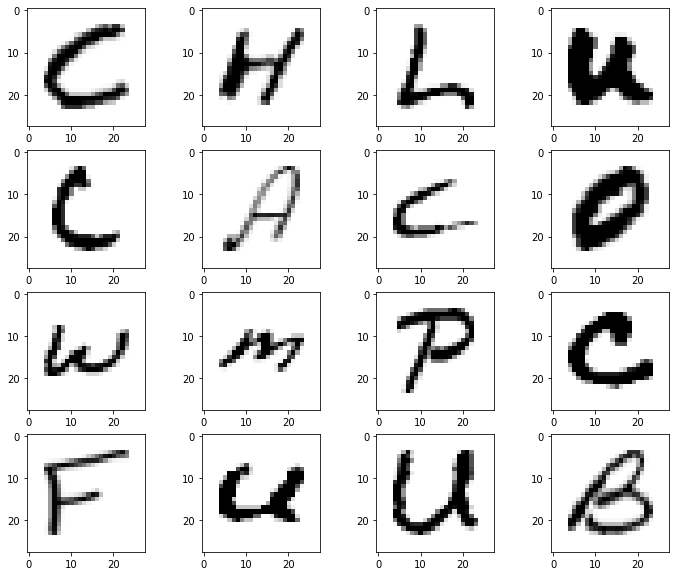

In [4]:
X_fshuffle = shuffle(X_f)

print("shape:",X_f.shape)
print("culoms count:",len(X_f.iloc[1]))
print("784 = 28X28")

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_fshuffle.iloc[i].values.reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

## assicuratici della bontà dei dati andiamo a controllarne la popolosità 

Amount of each labels


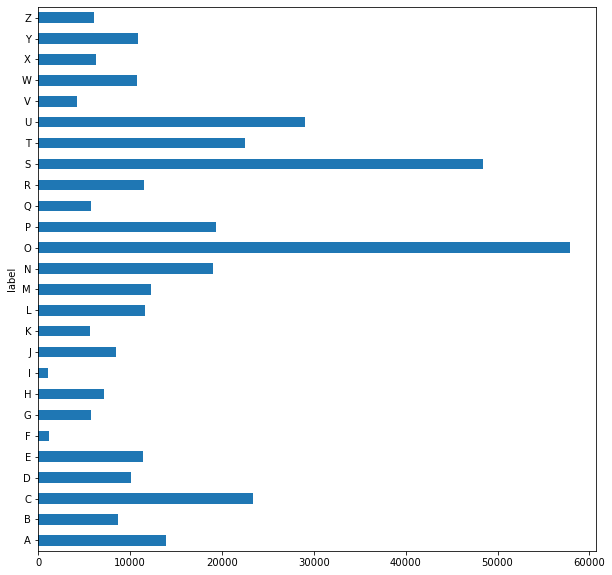

notiamo subito uno sbilanciamento
I count: 1120
F count: 1163


In [5]:
#creo la maschera per mappare gli indici ed esamino la popolosità del dataset 

print("Amount of each labels")

# Change label to alphabets
alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 
dataset_alphabets = dataset.copy()
dataset['label'] = dataset['label'].map(alphabets_mapper)

label_size = dataset.groupby('label').size()
label_size.plot.barh(figsize=(10,10))
plt.show()
print("notiamo subito uno sbilanciamento")
print("I count:", label_size['I'])
print("F count:", label_size['F'])

## abbiamo quindi uno sbilanciamento che penalizza la I e la F 

dato che il nostro dataset è molto numeroso uso il metodo RandomUnderSampler per andare a equilibrare il numero di  dati al pari della popolosità di I ( 1120*26 = 29120)

In [6]:
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(random_state=42)
#X, y = rus.fit_resample(X_f, y_f)
#X.shape, y.shape


In [7]:
X = X_f
y = y_f

### procedo dividendo il mio dataset in test_set e train_set ed andando a normalizzare e scalare i due 

In [8]:
X_train_full, X_test, y_train_full, y_test=train_test_split( X, y,
                                                            test_size=0.20,
                                                            random_state=42)
from sklearn.preprocessing import MinMaxScaler
# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train_full)

X_train_full = standard_scaler.transform(X_train_full)
X_test = standard_scaler.transform(X_test)
X_train , X_valid , y_train , y_valid = train_test_split( X_train_full,
                                                         y_train_full,
                                                         test_size=0.10,
                                                         random_state=45)

print(X_valid.shape, X_train.shape , X_test.shape,y_valid.shape, y_train.shape , y_test.shape) 


(29796, 784) (268164, 784) (74490, 784) (29796,) (268164,) (74490,)


dato che per la parte convoluzionale necessito di matrici 28X28 mentre per la parte iniziale lavorerò su array, copio i miei set di dati per allenare le reti sugli stessi dataset 

In [9]:
##copio i dataset per la parte convoluzionale e non 

X_train_C= X_train.copy()
X_valid_C=X_valid.copy()
X_test_C= X_test.copy()

y_train_C= y_train.copy()
y_valid_C=y_valid.copy()
y_test_C= y_test.copy()


preparo i dati per la parte convoluzionale 

In [10]:
## per la parte convoluzionale non posso tenere le immagini come array, 
#devono essere delle matrici 28X28X1

X_valid_C = X_valid_C.reshape(X_valid_C.shape[0], 28, 28, 1).astype('float32')
X_train_C = X_train_C.reshape(X_train_C.shape[0], 28, 28, 1).astype('float32')
X_test_C = X_test_C.reshape(X_test_C.shape[0], 28, 28, 1).astype('float32')

y_valid_C = np_utils.to_categorical(y_valid_C)
y_train_C = np_utils.to_categorical(y_train_C)
y_test_C = np_utils.to_categorical(y_test_C)


print(X_valid_C.shape, X_train_C.shape , X_test_C.shape,y_valid_C.shape, y_train_C.shape , y_test_C.shape) 

(29796, 28, 28, 1) (268164, 28, 28, 1) (74490, 28, 28, 1) (29796, 26) (268164, 26) (74490, 26)


### ora che i dati sono pronti procedo con il creare i due modelli 

In [20]:
print( X_train_full.shape )

(297960, 784)


In [11]:
#costruisco la mia struttura sequential 

model = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(len(y.unique()), activation="softmax")
])

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = "nadam" ,
              metrics =  ['accuracy']
             )

history = model.fit(X_train, y_train,
          epochs=10,
          validation_data=(X_test,y_test)
         )

Epoch 1/10
8381/8381 [==============================] - 100s 11ms/step - loss: 0.4026 - accuracy: 0.8884 - val_loss: 0.1280 - val_accuracy: 0.9633
Epoch 2/10
8381/8381 [==============================] - 1250s 149ms/step - loss: 0.1072 - accuracy: 0.9692 - val_loss: 0.1182 - val_accuracy: 0.9669
Epoch 3/10
8381/8381 [==============================] - 41s 5ms/step - loss: 0.0771 - accuracy: 0.9768 - val_loss: 0.0924 - val_accuracy: 0.9739
Epoch 4/10
8381/8381 [==============================] - 41s 5ms/step - loss: 0.0585 - accuracy: 0.9824 - val_loss: 0.0806 - val_accuracy: 0.9776
Epoch 5/10
8381/8381 [==============================] - 40s 5ms/step - loss: 0.0489 - accuracy: 0.9851 - val_loss: 0.0808 - val_accuracy: 0.9787
Epoch 6/10
8381/8381 [==============================] - 40s 5ms/step - loss: 0.0420 - accuracy: 0.9868 - val_loss: 0.0761 - val_accuracy: 0.9810
Epoch 7/10
8381/8381 [==============================] - 41s 5ms/step - loss: 0.0365 - accuracy: 0.9885 - val_loss: 0.0830 - 

NB  : maxpooling  (input_shape - pool_size + 1) / strides)

In [12]:

model_C = keras.models.Sequential([
    keras.layers.Conv2D(32, (5, 5), input_shape=(28, 28, 1),
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(len(y.unique()), activation="softmax")
])

model_C.compile(loss="categorical_crossentropy",
                optimizer= "nadam",
                metrics=["accuracy"])


history_C = model_C.fit(X_train_C, y_train_C, epochs=10, validation_data=(X_valid_C, y_valid_C))


Epoch 1/10
8381/8381 [==============================] - 256s 30ms/step - loss: 0.3075 - accuracy: 0.9133 - val_loss: 0.0690 - val_accuracy: 0.9799
Epoch 2/10
8381/8381 [==============================] - 243s 29ms/step - loss: 0.0813 - accuracy: 0.9759 - val_loss: 0.0564 - val_accuracy: 0.9834
Epoch 3/10
8381/8381 [==============================] - 228s 27ms/step - loss: 0.0595 - accuracy: 0.9822 - val_loss: 0.0443 - val_accuracy: 0.9869
Epoch 4/10
8381/8381 [==============================] - 245s 29ms/step - loss: 0.0517 - accuracy: 0.9846 - val_loss: 0.0445 - val_accuracy: 0.9873
Epoch 5/10
8381/8381 [==============================] - 241s 29ms/step - loss: 0.0445 - accuracy: 0.9868 - val_loss: 0.0364 - val_accuracy: 0.9895
Epoch 6/10
8381/8381 [==============================] - 249s 30ms/step - loss: 0.0383 - accuracy: 0.9883 - val_loss: 0.0387 - val_accuracy: 0.9900
Epoch 7/10
8381/8381 [==============================] - 362s 43ms/step - loss: 0.0350 - accuracy: 0.9895 - val_loss: 0

In [13]:
## valutiamo i nostri due modelli 
score = model.evaluate(X_test, y_test)
score_C = model_C.evaluate(X_test_C, y_test_C)

print("score per il non-convoluzionale ")
print( score )
print(" score per il convoluzionale ")
print(score_C)

2328/2328 [==============================] - 10s 4ms/step - loss: 0.0392 - accuracy: 0.9913
score per il non-convoluzionale 
[0.07648405432701111, 0.9835951328277588]
 score per il convoluzionale 
[0.039236314594745636, 0.9912605881690979]


rete non convoluzionale 


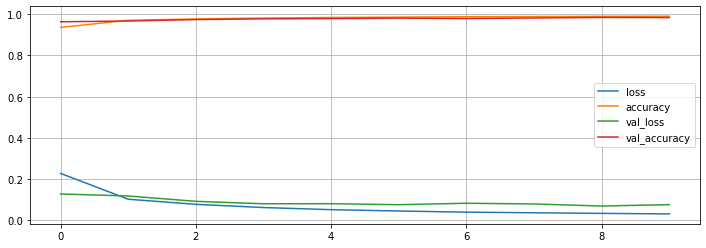

In [14]:
##vediamo graficamente la convergenza 

print("rete non convoluzionale ")
pd.DataFrame(history.history).plot(figsize=(12,4))
plt.grid(True)

rete convoluzionale 


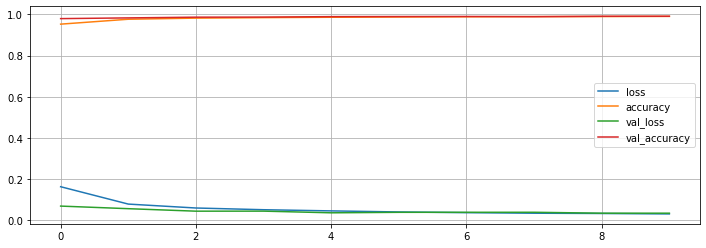

In [15]:
print("rete convoluzionale ")
pd.DataFrame(history_C.history).plot(figsize=(12,4))
plt.grid(True)


C:\Users\vigan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


non convoluzionale 


<AxesSubplot:>

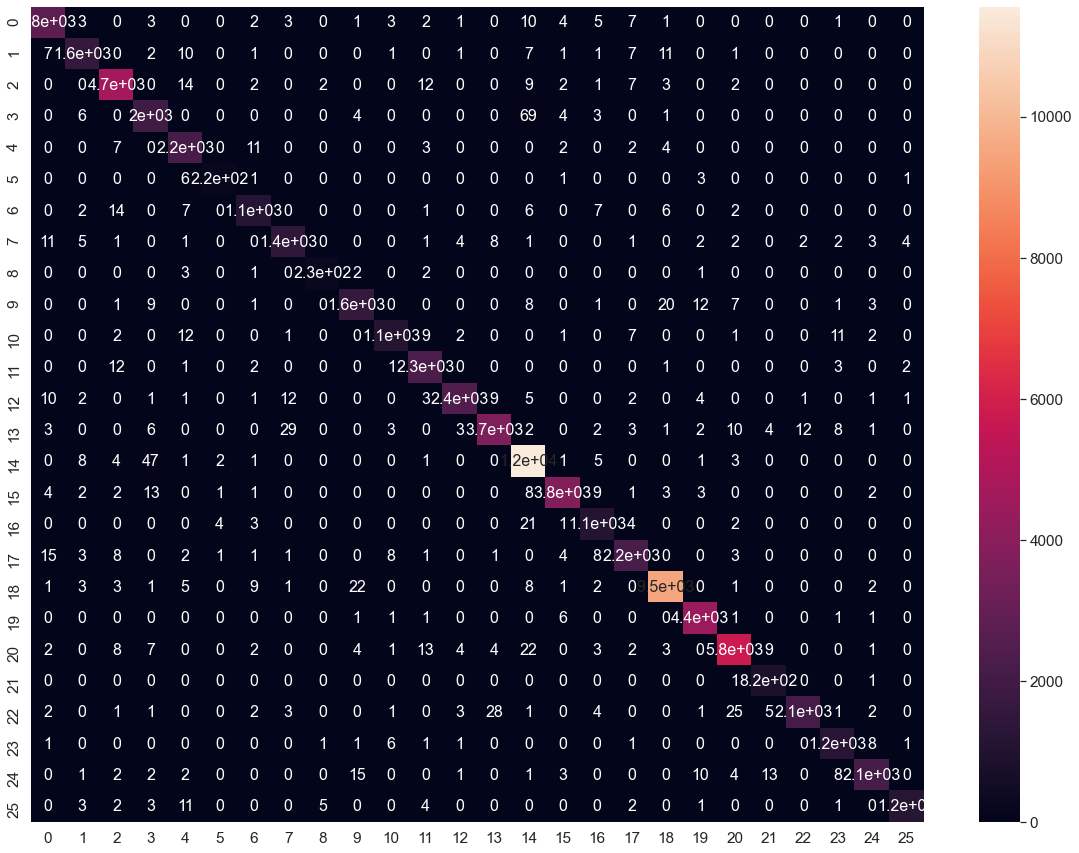

In [17]:
 ##ed infinse confrontiamo le due confusion matrix
y_pred = model.predict_classes(X_test)


from sklearn.metrics import confusion_matrix
print("non convoluzionale ")

cm=confusion_matrix(y_test,y_pred)

df_cm = pd.DataFrame(cm, range(26),range(26))
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size



convoluzionale 


C:\Users\vigan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<AxesSubplot:>

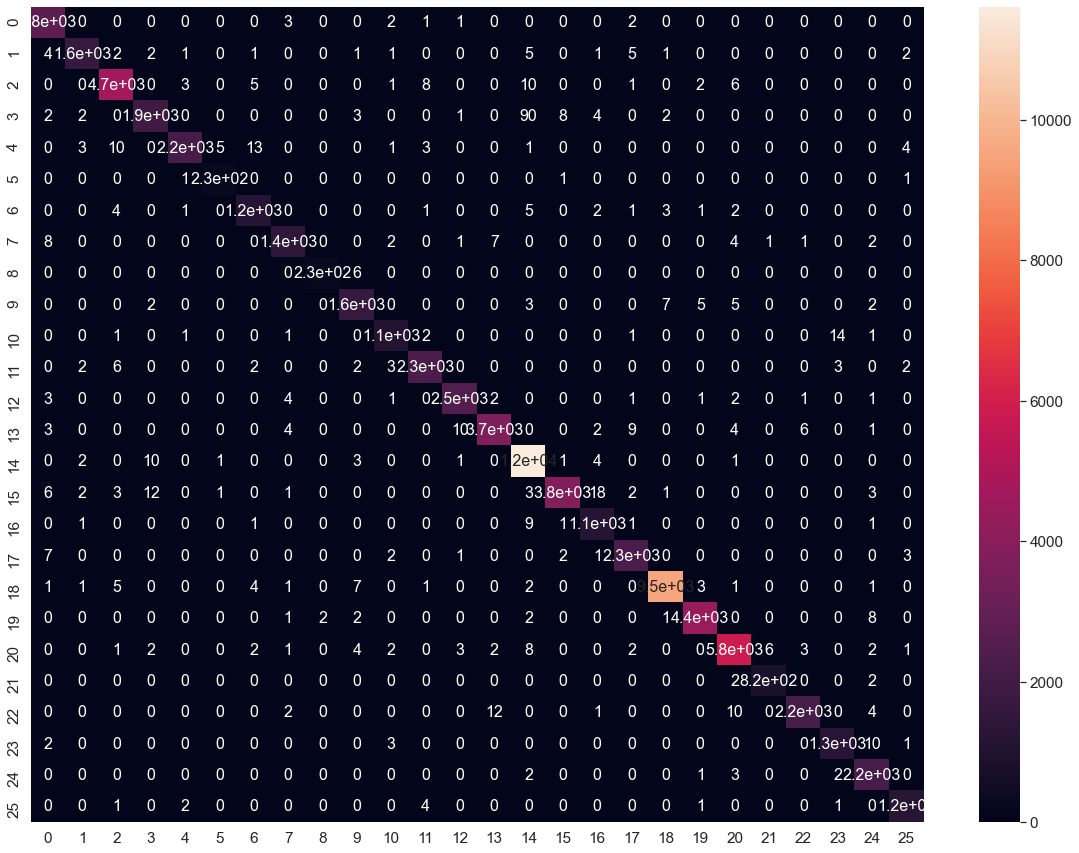

In [18]:
print("convoluzionale ")

y_pred_C = model_C.predict_classes(X_test_C)
rounded_labels=np.argmax(y_test_C, axis=1)
#rounded_predictions = model.predict_classes(X_test, batch_size=128, verbose=0)
cm_C = confusion_matrix(rounded_labels, y_pred_C)

df_cm = pd.DataFrame(cm_C, range(26),range(26))
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font sizeq